In [1]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go

# Load data

In [105]:
df = pd.read_excel('./RESULTS/set_0/RESULTS_set_0_main_profiler_result.xlsx')
df = df.fillna(0)

In [121]:
conditions = [0, 1]  # condition 0: 13CO2, condition 1: 12CO2

labeled_fractions_samples = {}
for c in conditions:
    # iterate over both conditions
    labeled_fractions_samples[c] = {}
    
    for aa in df['compound'].unique():
        # iterate over all amino acids that we looked for in the LC/MS raw data
        if aa in ['Trp', 'Met', 'Cys']:
            # no Trp, Cys not detected, Met not detected for one replicate
            continue
        
        labeled_fractions_samples[c][aa] = {}
        df_aa_c = df[(df['sample_group' ] == c) & (df['compound'] == aa)]
        for s in df_aa_c['plot'].unique():
            # iterate over replicate samples
            df_aa_c_s = df_aa_c[df_aa_c['plot'] == s]
            no_carbons = int(df_aa_c_s['num_c'].max())
            
            # compute labeled fraction
            labeled_fraction = 0
            for i in range(no_carbons+1):  
                labeled_fraction += df_aa_c_s[df_aa_c_s['mi'] == i]['mi_fraction'].values[0] * i/no_carbons

            labeled_fractions_samples[c][aa][s] = labeled_fraction

In [122]:
# compute summary statistics for each amino acid
labeled_fractions_means = {}
for c in conditions:
    # iterate over both conditions
    labeled_fractions_means[c] = []
    for aa in df['compound'].unique():
        # iterate over all amino acids that we looked for in the LC/MS raw data
        if aa in ['Trp', 'Met', 'Cys']:
            # no Trp, Cys not detected, Met not detected for one replicate
            continue
        
        mean = np.mean(list(labeled_fractions_samples[c][aa].values()))
        std = np.std(list(labeled_fractions_samples[c][aa].values()))
        labeled_fractions_means[c].append({'aa': aa, 'mean': mean, 'std': std})

df_12CO2 = pd.DataFrame(labeled_fractions_means[1]).sort_values('aa')
df_13CO2 = pd.DataFrame(labeled_fractions_means[0]).sort_values('aa')

# Plot data

In [123]:
def bar_chart(names, y, errors, title, fn, dp_overlay=None):
    if errors is None:
        data = [go.Bar(x=names, y=y, marker_color='rgb(39, 125, 161)')]
    else:
        data = [go.Bar(x=names, y=y, error_y={'type': 'data', 'array':errors}, marker_color='rgb(44, 105, 154)')]

    # overlay individual datapoints
    if dp_overlay is not None:
        # dp_overlay is a dict with the same keys as the "names" variable and contains individual datapoints to be plotted on top of the bar chars
        data_overlay = [go.Box(y=list(dp_overlay[x].values()), boxpoints='all', name=x, jitter=0.5, pointpos=0.25, fillcolor='rgba(255,255,255,0)', hoveron='points', marker={'line':{'width':1.5, 'color': 'rgb(242, 158, 76)'}, 'opacity':0.75, 'color':'rgba(0,0,0,0)'}, line={'color':'rgba(255,255,255,0)'}) for x in names]
        data.extend(data_overlay)


    
    # define plot layout
    layout = go.Layout(margin = {'l':0, 'r':0, 't':50, 'b':0},
                       height = 250,
                       width = 300,
                       showlegend = False,
                     
                       yaxis = {'title': '<sup>13</sup>C labeled fraction', 'dtick': 0.25, 'domain': [0,0.95], 'range': [-0.03, 1.1]},
                       
                       paper_bgcolor = 'rgba(0,0,0,0)',
                       plot_bgcolor = 'rgba(0,0,0,0)',
                        
                       font_family = 'Arial',
                       font_size = 14,
                       title = {'text': title, 
                                'x':0.5, 'y': 1, 'xref': 'paper', 'yref': 'paper',
                               'xanchor': 'center','yanchor': 'bottom'},
                      )


    # define figure
    fig = go.Figure(data=data, layout=layout)
    

    # write figure
    fig.write_image('./{}_labeled_fraction.png'.format(fn))
    fig.write_image('./{}_labeled_fraction.pdf'.format(fn))
    fig.show()

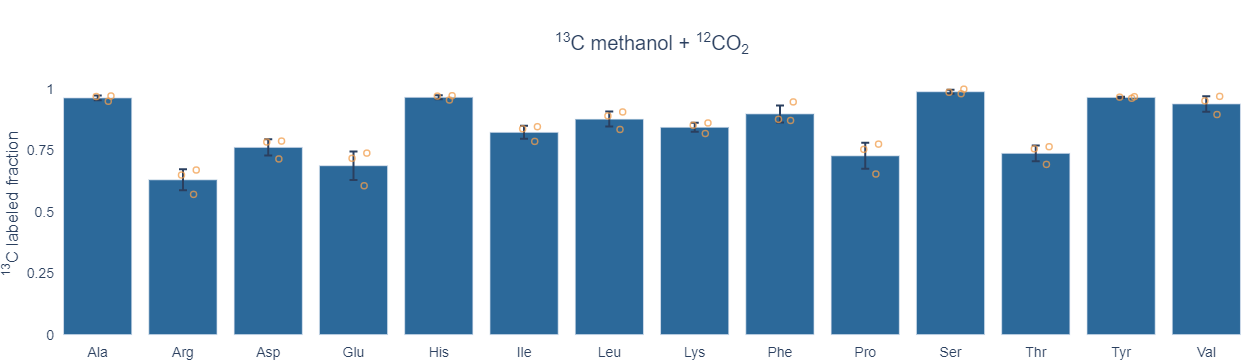

In [124]:
# plot 12CO2 data
bar_chart(df_12CO2['aa'], df_12CO2['mean'], df_12CO2['std'], '<sup>13</sup>C methanol + <sup>12</sup>CO<sub>2</sub>', '12CO2', dp_overlay=labeled_fractions_samples[1])

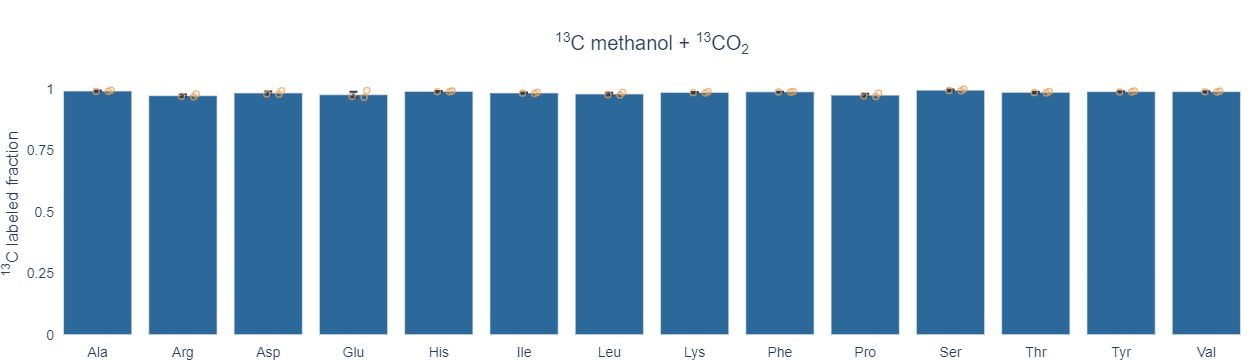

In [125]:
# plot 13CO2 data
bar_chart(df_13CO2['aa'], df_13CO2['mean'], df_13CO2['std'], '<sup>13</sup>C methanol + <sup>13</sup>CO<sub>2</sub>', '13CO2', dp_overlay=labeled_fractions_samples[0],)